### Problem3
Let's use `cvxpy` package to solve this SOCP optimization problem.

In [2]:
import cvxpy as cp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import time

In [3]:
# 处理和定义数据集
# Import datasets: breastcancer(bc), pima, sonar
data_pima = pd.read_csv("diabetes.csv")
data_bc = pd.read_csv("breast-cancer-wisconsin.txt",sep='\t',header=None)
data_sonar = pd.read_csv("sonar_csv.csv")

# Data processing
data_pima.head() # class: 1/0, the last column named 'Outcome'
data_bc.head() # class: 1/0, the last column named '10'
data_bc.drop(columns=0,inplace=True)
data_sonar.head() # class: not 1/0! The last column named 'Class'
set(data_sonar['Class']) # {'Mine', 'Rock'}
# Convert 'Mine' to 0, 'Rock' to 1
data_sonar['Class'].replace(["Mine","Rock"],[0,1],inplace = True)
set(data_sonar['Class'])

# 删除含非数值元素的行
def to_numeric(df):
    # print("Before deleting:",df.shape)
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df = df.dropna(subset=[col],axis=0)
    # print("After deleting:",df.shape)
    return df
data_bc = to_numeric(data_bc)

# 定义字典存放三个数据集
datasets = {
    "pima": data_pima,
    "breast_cancer": data_bc,
    "sonar": data_sonar
}
print("Dataset loading complete.")

Dataset loading complete.


In [4]:
# Define function to calculate Sigma_p, Sigma_n, mu_p, mu_n
def cal_moments(data):
    n = data.shape[1] # number of columns
    y = data.iloc[:,-1] # define y
    X_p = data[y==1].iloc[:,0:n-1] # define X_positive (y==1)
    X_n = data[y==0].iloc[:,0:n-1] # define X_negative (y==0)
    mu_p = np.mean(X_p,axis=0)
    mu_n = np.mean(X_n,axis=0)
    Sigma_p = np.cov(X_p, rowvar = False)
    Sigma_n = np.cov(X_n, rowvar = False)
    return mu_p, mu_n, Sigma_p, Sigma_n

In [5]:
# 计算不同X,y对应的w和b
def cal_opt(data):
    # Define the data
    mu_p, mu_n, Sigma_p, Sigma_n = cal_moments(data)
    dim = mu_p.shape[0]

    # Define the variables
    w = cp.Variable(dim)

    # Define the objective function
    ## 计算协方差阵的1/2
    evalue_n, evector_n = np.linalg.eig(Sigma_n)
    half_Sigma_n = evector_n @ np.diag(np.sqrt(evalue_n)) @ evector_n.T
    evalue_p, evector_p = np.linalg.eig(Sigma_p)
    half_Sigma_p = evector_p @ np.diag(np.sqrt(evalue_p)) @ evector_p.T
    ## 送入目标函数
    goal = cp.norm(half_Sigma_n @w,2)+cp.norm(half_Sigma_p@w,2)

    # Define the constraint
    soc_constraints = [w @ (mu_p-mu_n) == 1]

    # Define the problem
    prob = cp.Problem(cp.Minimize(goal),soc_constraints)

    # Solve the problem
    try:
        prob.solve()
        # Print the result
        w_opt = w.value
        b_opt = w_opt@mu_n + np.sqrt(np.dot(w_opt@Sigma_n,w_opt))/(np.sqrt(np.dot(w_opt@Sigma_n,w_opt))+
                                                                np.sqrt(np.dot(w_opt@Sigma_p,w_opt)))
        # print("The optimal w:",w_opt)
        # print("The optimal b:",b_opt)
    except Exception as e:
        print(e)
    return w_opt,b_opt

In [6]:
# Define the MPM classifier
def MPM(data):
    n = data.shape[1] # number of columns
    y = data.iloc[:,-1] # define y
    X = data.iloc[:,0:n-1] # define X
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

    # Use the training data to calculate w and b
    data_train = pd.concat([X_train,y_train],axis = 1)
    w,b = cal_opt(data_train)

    # predict
    data_test = pd.concat([X_test,y_test],axis = 1)
    i_p = X_test[X_test @ w - b > 0].index
    i_n = X_test[X_test @ w - b < 0].index
    data_test['pre'] = [0 for i in range(len(X_test))]
    data_test['pre'][i_p] = [1 for i in range(len(i_p))] # w^X-b>0的标签定义为1

    # calculate the accuracy
    acc = sum(data_test['pre'] == y_test)/len(data_test) # 测试集准确率
    # print("Accuracy:",acc)

    # calculate the error
    mu_p, mu_n, Sigma_p, Sigma_n = cal_moments(data_train)
    k = 1/(np.sqrt(w @ Sigma_n @ w.T)+np.sqrt(w @ Sigma_p @ w.T))
    err = 1/(k**2 + 1)
    # print("Error:",err)
    return acc, err

In [7]:
# run MPM for 10 times and calculate the average acc & err
time_start = time.perf_counter()
for name, data in zip(datasets.keys(), datasets.values()):
    accs = []
    errs = []
    for i in range(10):
        # print("Round",i)
        acc, err = MPM(data)
        accs.append(acc)
        errs.append(err)
    average_acc = np.mean(accs)
    average_err = np.mean(errs)
    print("Dataset:",name)
    print("    average accuracy:",average_acc)
    print("    average error:",average_err)
time_end = time.perf_counter()
run_time = time_end - time_start
print("MPM running time:", run_time)

Dataset: pima
    average accuracy: 0.735064935064935
    average error: 0.6761572448656572
Dataset: breast_cancer
    average accuracy: 0.9768115942028986
    average error: 0.15619720325214242
Dataset: sonar
    average accuracy: 0.7333333333333334
    average error: 0.3548888756177835
MPM running time: 0.7394593329999992


In [8]:
# run LDA, Logistic Regression, and SVM
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
models = {
    "Logistic Regression": LogisticRegression(), # penalty, C
    "LDA": LinearDiscriminantAnalysis(),
    "SVM": SVC() # kernel, C
}

In [9]:
for model_name, model in models.items():
    print(model_name)
    time_start = time.perf_counter()
    for name, data in zip(datasets.keys(), datasets.values()):
        accs = []
        errs = []
        n = data.shape[1] # number of columns
        y = data.iloc[:,-1] # define y
        X = data.iloc[:,0:n-1] # define X
        for i in range(10):
            # print("Round",i)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = sum(y_test == y_pred)/len(y_test)
            accs.append(acc)
        average_acc = np.mean(accs)
        print("    Dataset:",name)
        print("        average accuracy:",average_acc)
    time_end = time.perf_counter()
    run_time = time_end - time_start
    print("    Running time:", run_time)

Logistic Regression
    Dataset: pima
        average accuracy: 0.7779220779220779
    Dataset: breast_cancer
        average accuracy: 0.9753623188405797
    Dataset: sonar
        average accuracy: 0.7904761904761903
    Running time: 1.1015612920000013
LDA
    Dataset: pima
        average accuracy: 0.7428571428571428
    Dataset: breast_cancer
        average accuracy: 0.9536231884057971
    Dataset: sonar
        average accuracy: 0.7142857142857142
    Running time: 0.35569416600000103
SVM
    Dataset: pima
        average accuracy: 0.7714285714285716
    Dataset: breast_cancer
        average accuracy: 0.9782608695652174
    Dataset: sonar
        average accuracy: 0.8142857142857143
    Running time: 0.6479802919999997


### Problem4

In [10]:
# Define the parameters
mu_1 = np.array([0,0])
mu_2 = np.array([4,2])
Sigma_1 = np.array([[4,-1],[-1,1]])
Sigma_2 = np.array([[1,1],[1,2]])
dim = 2

First, let's calculate $\kappa$ using the same method above.

In [11]:
# Define the variables
w = cp.Variable(dim)

# Define the objective function
## 计算协方差阵的1/2
evalue_1, evector_1 = np.linalg.eig(Sigma_1)
half_Sigma_1 = evector_1 @ np.diag(np.sqrt(evalue_1)) @ evector_1.T
evalue_2, evector_2 = np.linalg.eig(Sigma_2)
half_Sigma_2 = evector_2 @ np.diag(np.sqrt(evalue_2)) @ evector_2.T
## 送入目标函数
goal = cp.norm(half_Sigma_1 @w,2)+cp.norm(half_Sigma_2@w,2)

# Define the constraint
soc_constraints = [w @ (mu_2-mu_1) == 1]

# Define the problem
prob = cp.Problem(cp.Minimize(goal),soc_constraints)

# Solve the problem
prob.solve()
# Print the result
w_opt = w.value
k_opt = 1/(np.sqrt(w_opt @ Sigma_1 @ w_opt.T)+np.sqrt(w_opt @ Sigma_2 @ w_opt.T))
print("Optimal Kappa:",k_opt)

Optimal Kappa: 1.512154700499445


Then let's draw ellipsoids with different $\kappa$ to find the smallest one that makes 2 ellipsoinds intersect.

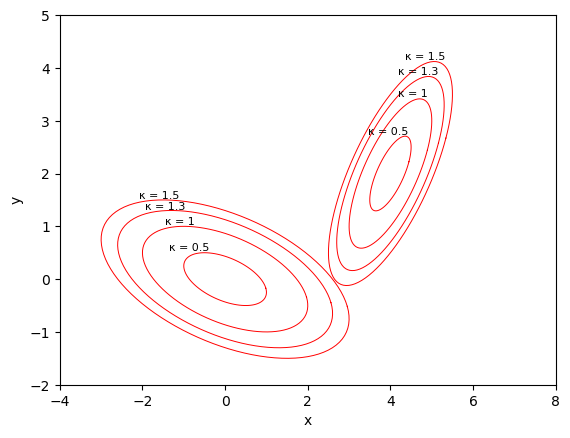

In [70]:
import matplotlib.pyplot as plt

mu_mean = (mu_1 + mu_2) / 2
plt.xlim(mu_mean[0] - 6, mu_mean[0] + 6)
plt.ylim(mu_mean[1] - 3, mu_mean[1] + 4)
plt.xlabel("x")
plt.ylabel("y")

def draw(k, flag):
    mu = mu_1
    Sigma = Sigma_1
    if flag == 2:
        mu = mu_2
        Sigma = Sigma_2

    ## 计算协方差阵的1/2
    eigenvalues, eigenvectors = np.linalg.eig(Sigma)
    half_Sigma = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    # max_eigenvalue_index = np.argmax(eigenvalues)
    # max_eigenvector = eigenvectors[:, max_eigenvalue_index]
    # lambda_1 = eigenvalues[np.argmax(eigenvalues)]
    # lambda_2 = eigenvalues[np.argmin(eigenvalues)]
    # angle = np.rad2deg(np.arctan2(max_eigenvector[1], max_eigenvector[0]))
    # cos = np.cos(np.deg2rad(angle))
    # sin = np.sin(np.deg2rad(angle))

    u = np.linspace(0, 2 * np.pi, 100)
    # x_0 = mu[0] + np.sqrt(lambda_1) * k * np.cos(u)
    # y_0 = mu[1] + np.sqrt(lambda_2) * k * np.sin(u)
    # x = x_0 * cos - y_0 * sin
    # y = x_0 * sin + y_0 * cos
    x = []
    y = []
    for i in range(100):
        cord = np.array([k * np.cos(u[i]), k * np.sin(u[i])])
        cord = mu + half_Sigma @ cord
        x.append(cord[0])
        y.append(cord[1])
    plt.plot(x, y, color='red', linewidth=0.7,label=f'κ = {k}')
    if flag == 2:
        plt.text(x[0], y[20], f'κ = {k}', ha='right', va='bottom',fontsize=8)
    else:
        plt.text(x[28], y[28], f'κ = {k}', ha='right', va='bottom',fontsize=8)

k_values = [0.5,1,1.3,1.5]
for k in k_values:
    draw(k, 1)
    draw(k, 2)
plt.show()